### MPDA - Flappy Bird Reinforcement Learning


### PROGRESS:
[Date] [Name]: [What was done]

[30.11.] [mszuc]: [Team work templates, Define tasks for project]

[1.12.] [xsocha02]: [Added random baseline agent + video/GIF]


### BLOCKERS:
None yet

### DECISIONS:
- Using flappy-bird-gymnasium package for environment
- Starting with simple feature space (12 values)
- PyTorch for neural networks

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 0: SETUP & INSTALLATION
# ═══════════════════════════════════════════════════════════

!pip install flappy-bird-gymnasium torch torchvision matplotlib imageio

import gymnasium as gym
import flappy_bird_gymnasium
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from gymnasium.wrappers import RecordVideo
import imageio
from moviepy.video.io.VideoFileClip import VideoFileClip


In [ ]:
# Test environment loads
env = gym.make('FlappyBird-v0', render_mode='rgb_array', use_lidar=True)
print(f"✅ Environment loaded!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

✅ Environment loaded!
Observation space: Box(0.0, 1.0, (180,), float64)
Action space: Discrete(2)


array([[[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202]],

       ...,

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]]], dtype=uint8)
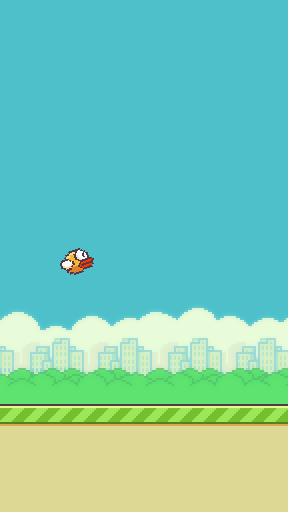

In [ ]:
# Render test
env.reset()
env.render()

array([[[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 84,  56,  71],
        [ 84,  56,  71]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 84,  56,  71],
        [ 84,  56,  71]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [ 78, 192, 202],
        [ 84,  56,  71],
        [ 84,  56,  71]],

       ...,

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]]], dtype=uint8)
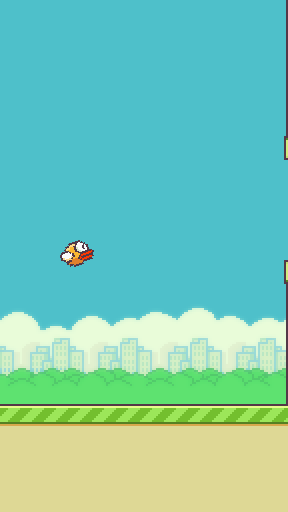

In [ ]:
action = 0
env.step(action)

env.render()

array([[[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [132, 169,  68],
        [148, 183,  81],
        [148, 183,  81]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [132, 169,  68],
        [148, 183,  81],
        [148, 183,  81]],

       [[ 78, 192, 202],
        [ 78, 192, 202],
        [ 78, 192, 202],
        ...,
        [132, 169,  69],
        [148, 184,  80],
        [148, 184,  80]],

       ...,

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]],

       [[222, 216, 149],
        [222, 216, 149],
        [222, 216, 149],
        ...,
        [222, 216, 149],
        [222, 216, 149],
        [222, 216, 149]]], dtype=uint8)
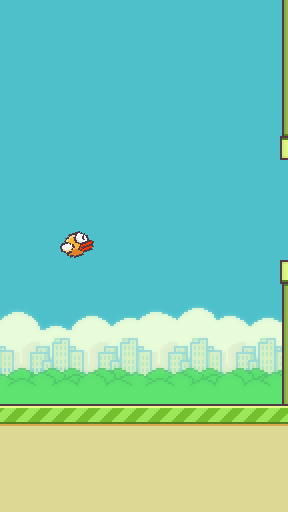

In [ ]:
action = 1
env.step(action)

env.render()

In [ ]:
env.close()

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 1: HYPERPARAMETERS
# ═══════════════════════════════════════════════════════════

LEARNING_RATE = 1e-3
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 100
NUM_EPISODES = 1000

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 2: ENVIRONMENT EXPLORATION
# ═══════════════════════════════════════════════════════════

def explore_environment():
    """
    Understand state/action space of Flappy Bird.
    Prints shapes, runs random episode.
    """
    # TODO: Implement exploration
    observation, info = env.reset()
    print(f"Observation shape: {observation.shape}")
    print(f"Info: {info}")

    print(f"Last 10 values: {observation[-10:]}")

    # jump
    action = 1
    observation, reward, terminated, truncated, info = env.step(action)

    # bird jumped up => lower values increased
    print(f"After action: {observation[-10:]}")

    # don't jump
    action = 0
    observation, reward, terminated, truncated, info = env.step(action)

    # still rising
    print(f"After action: {observation[-10:]}")
    action = 0

env = gym.make('FlappyBird-v0', render_mode='rgb_array', use_lidar=True)
explore_environment()
env.close()

Observation shape: (180,)
Info: {'score': 0}
Last 10 values: [0.87077653 0.86325566 0.85355176 0.84422975 0.83749654 0.83099074
 0.82471771 0.81868282 0.81289137 0.80734859]
After action: [0.92584822 0.91578435 0.90606844 0.8967118  0.88772578 0.88123633
 0.87496653 0.86892114 0.86310487 0.85752239]
After action: [0.97139963 0.96137938 0.95169132 0.9423457  0.93335279 0.92684578
 0.91849489 0.91248114 0.90668591 0.90111343]


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 3: RANDOM BASELINE AGENT
# ═══════════════════════════════════════════════════════════

def random_agent_baseline(env, num_episodes=10):
    """
    Random agent for baseline performance.

    Returns:
        avg_score: Average score over episodes
        avg_steps: Average survival time
    """
    scores = []
    steps = []
    for episode in range(num_episodes):
        observation, info = env.reset()
        done = False
        score = 0
        steps_taken = 0
        while not done:
            action = env.action_space.sample()
            observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            done = terminated or truncated
            steps_taken += 1
        scores.append(score)
        steps.append(steps_taken)

    avg_score = np.mean(scores)
    avg_steps = np.mean(steps)

    return avg_score, avg_steps

env = gym.make('FlappyBird-v0', render_mode='rgb_array', use_lidar=True)
env = RecordVideo(env, 'random_agent_video', episode_trigger=lambda x: True)
avg_score, avg_steps = random_agent_baseline(env)
env.close()

print(f"Average score: {avg_score}")
print(f"Average steps: {avg_steps}")
print("Videos saved in /content/random_agent_video/")

# convert to gif
video = VideoFileClip("random_agent_video/rl-video-episode-0.mp4")
video.write_gif("random_agent.gif", fps=30, program='ffmpeg')
print("GIF saved in /content/random_agent.gif")

# When randomly choosing actions, bird almost always flies up to the top of the screen

  logger.warn(



Average score: -7.679999999999998
Average steps: 50.0
Videos saved in /content/random_agent_video/
MoviePy - Building file  random_agent.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: random_agent.gif.
GIF saved in /content/random_agent.gif


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 4: DQN NETWORK
# ═══════════════════════════════════════════════════════════

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        """
        Deep Q-Network.

        Args:
            state_dim: Dimension of state space (12 for features, 180 for LIDAR)
            action_dim: Number of actions (2: nothing/flap)
        """
        super(DQN, self).__init__()

        # 2–3 fully connected layers with ReLU
        hidden1 = 128
        hidden2 = 128

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, action_dim)
        )

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: State tensor [batch_size, state_dim]

        Returns:
            Q-values: [batch_size, action_dim]
        """
        return self.net(x)


# -----------------------------------------------------------
# Model Save / Load
# -----------------------------------------------------------

def save_dqn(model, path):
    """
    Save DQN model weights to file.
    """
    torch.save(model.state_dict(), path)


def load_dqn(path, state_dim, action_dim, device="cpu"):
    """
    Load DQN model weights from file.

    Returns:
        model: DQN instance with loaded weights (in eval mode)
    """
    model = DQN(state_dim, action_dim).to(device)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model


#test
env = gym.make('FlappyBird-v0', use_lidar=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = DQN(state_dim, action_dim)
test_state = torch.randn(1, state_dim)   # fake input
q_values = model(test_state)

print("State dim:", state_dim)
print("Action dim:", action_dim)
print("Q-values:", q_values)

State dim: 180
Action dim: 2
Q-values: tensor([[ 0.0668, -0.1172]], grad_fn=<AddmmBackward0>)


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 5: EXPERIENCE REPLAY BUFFER
# ═══════════════════════════════════════════════════════════

from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        """
        Experience replay buffer.

        Args:
            capacity: Maximum number of experiences to store
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)   # auto-removes old items

    def push(self, state, action, reward, next_state, done):
        """Store one experience into the buffer."""
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        """Sample a random batch of experiences."""
        batch = random.sample(self.buffer, batch_size)

        # Unzip the batch
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to NumPy arrays (PyTorch will convert later)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        """Return current size of the buffer."""
        return len(self.buffer)


#test
buf = ReplayBuffer(100)

buf.push([1,2,3], 1, 0.5, [1,2,4], False)
buf.push([4,5,6], 0, 1.0, [4,5,7], True)

print("Buffer size:", len(buf))
batch = buf.sample(2)

print("Sampled states:", batch[0])
print("Sampled actions:", batch[1])

Buffer size: 2
Sampled states: [[4 5 6]
 [1 2 3]]
Sampled actions: [0 1]


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 6: DQN AGENT
# ═══════════════════════════════════════════════════════════

class DQNAgent:
    def __init__(self, state_dim, action_dim, device=None):
        """
        DQN Agent with target network.

        Args:
            state_dim: State space dimension
            action_dim: Action space dimension
        """
        self.state_dim = state_dim
        self.action_dim = action_dim

        # Device (CPU / GPU)
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        # Hyperparameters
        self.gamma = 0.99           # discount factor
        self.batch_size = 64
        self.learning_rate = 1e-3
        self.replay_capacity = 50_000
        self.min_buffer_size = 1_000  # start training only after this many transitions

        # Networks
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # target net in eval mode

        # Optimizer & loss
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.replay_capacity)

    def select_action(self, state, epsilon):
        """
        Epsilon-greedy action selection.

        Args:
            state: Current state (np.array shape [state_dim])
            epsilon: Exploration probability

        Returns:
            action: 0 or 1
        """
        # Explore
        if random.random() < epsilon:
            return random.randrange(self.action_dim)

        # Exploit
        state_tensor = torch.tensor(
            state, dtype=torch.float32, device=self.device
        ).unsqueeze(0)  # [1, state_dim]

        with torch.no_grad():
            q_values = self.policy_net(state_tensor)  # [1, action_dim]
            action = q_values.argmax(dim=1).item()

        return action

    def train_step(self):
        """
        Sample batch and update network.

        Returns:
            loss_value: float or None (if not enough data)
        """
        # Don't train until buffer has enough samples
        if len(self.replay_buffer) < max(self.batch_size, self.min_buffer_size):
            return None

        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states      = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions     = torch.tensor(actions, dtype=torch.long,   device=self.device).unsqueeze(1)   # [B,1]
        rewards     = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1) # [B,1]
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones       = torch.tensor(dones, dtype=torch.float32,  device=self.device).unsqueeze(1)  # [B,1]

        # Current Q-values from policy network for taken actions
        q_values = self.policy_net(states).gather(1, actions)  # [B,1]

        # Target Q-values using target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(dim=1, keepdim=True)[0]  # [B,1]
            target_q_values = rewards + self.gamma * (1.0 - dones) * next_q_values

        # Compute loss
        loss = self.loss_fn(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        # (Optional) gradient clipping:
        # torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Copy weights from policy to target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

env = gym.make("FlappyBird-v0", use_lidar=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

state, _ = env.reset()
action = agent.select_action(state, epsilon=0.5)
print("Sampled action:", action)

env.close()

Sampled action: 0


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 7: TRAINING LOOP
# ═══════════════════════════════════════════════════════════

def train_dqn(agent, env, num_episodes):
    """
    Main training loop.

    Args:
        agent: DQNAgent instance
        env: Gymnasium environment
        num_episodes: Number of episodes to train

    Returns:
        rewards: List of episode rewards
        losses: List of training losses (avg per episode)
    """
    rewards = []
    losses = []

    epsilon = EPSILON_START
    global_step = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0
        episode_losses = []

        while not done:
            # --- Epsilon-greedy action selection ---
            action = agent.select_action(state, epsilon)

            # --- Interact with environment ---
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # --- Store experience in replay buffer ---
            agent.replay_buffer.push(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward

            # --- Train on a random batch from replay buffer ---
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)

            global_step += 1

            # --- Periodically update target network ---
            if global_step % TARGET_UPDATE == 0:
                agent.update_target_network()

            # --- Decay epsilon (exploration) ---
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # end of episode
        rewards.append(episode_reward)
        if episode_losses:
            avg_loss = np.mean(episode_losses)
        else:
            avg_loss = 0.0
        losses.append(avg_loss)

        print(
            f"Episode {episode + 1}/{num_episodes} | "
            f"Reward: {episode_reward:.2f} | "
            f"Avg loss: {avg_loss:.4f} | "
            f"Epsilon: {epsilon:.3f}"
        )

    return rewards, losses

#test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("FlappyBird-v0", use_lidar=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, device=device)

rewards, losses = train_dqn(agent, env, NUM_EPISODES)

env.close()

Episode 1/1000 | Reward: -7.50 | Avg loss: 0.0000 | Epsilon: 0.778
Episode 2/1000 | Reward: -6.30 | Avg loss: 0.0000 | Epsilon: 0.606
Episode 3/1000 | Reward: -0.90 | Avg loss: 0.0000 | Epsilon: 0.471
Episode 4/1000 | Reward: -4.50 | Avg loss: 0.0000 | Epsilon: 0.367
Episode 5/1000 | Reward: -0.90 | Avg loss: 0.0000 | Epsilon: 0.286
Episode 6/1000 | Reward: 0.90 | Avg loss: 0.0000 | Epsilon: 0.222
Episode 7/1000 | Reward: -0.90 | Avg loss: 0.0000 | Epsilon: 0.173
Episode 8/1000 | Reward: 1.40 | Avg loss: 0.0000 | Epsilon: 0.144
Episode 9/1000 | Reward: -0.90 | Avg loss: 0.0000 | Epsilon: 0.112
Episode 10/1000 | Reward: -2.00 | Avg loss: 0.0000 | Epsilon: 0.084
Episode 11/1000 | Reward: 0.90 | Avg loss: 0.0000 | Epsilon: 0.065
Episode 12/1000 | Reward: 0.80 | Avg loss: 0.0000 | Epsilon: 0.056
Episode 13/1000 | Reward: -0.90 | Avg loss: 0.0000 | Epsilon: 0.044
Episode 14/1000 | Reward: 0.80 | Avg loss: 0.0000 | Epsilon: 0.037
Episode 15/1000 | Reward: 0.80 | Avg loss: 0.0000 | Epsilon: 0

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 8: HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════

def plot_training_results(rewards, losses):
    """Plot reward curves and training losses."""
    # TODO: Implement plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.show()

def save_model(agent, filepath):
    """Save model weights (agent's primary Q-Network: policy_net)."""
    torch.save(agent.policy_net.state_dict(), filepath)
    print(f"✅ Model saved to {filepath}")

def load_model(agent, filepath):
    """Load model weights into agent's primary Q-Network: policy_net."""
    state_dict = torch.load(filepath, map_location=agent.device)
    agent.policy_net.load_state_dict(state_dict)
    agent.policy_net.eval() # Set network to evaluation mode after loading
    print(f"✅ Model loaded from {filepath}")
    return agent

def record_video(env, agent, filename):
    """Record agent gameplay video."""
    # Set a seed for consistent visualization
    SEED = 42

    # 1. Wrap the environment for recording.
    video_env = RecordVideo(env, filename, episode_trigger=lambda x: True, name_prefix='eval_run')

    # 2. Run an episode
    state, _ = video_env.reset(seed=SEED)
    done = False
    total_reward = 0
    step = 0

    while not done:
        # *** FIX: Using agent.select_action and epsilon=0.0 ***
        # Action selection uses the trained agent's greedy policy
        action = agent.select_action(state, epsilon=0.0)

        next_state, reward, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
        step += 1

    video_env.close()
    print(f"✅ Video recorded in the '{filename}' directory. Total Reward: {total_reward:.2f}, Steps: {step}")


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 9.5: VIDEO
# ═══════════════════════════════════════════════════════════

LIDAR_OBS = True
ENV_ID = 'FlappyBird-v0'

MODEL_PATH = 'flappy_bird_dqn_v1.pth' # Must match the save path
VIDEO_FOLDER = './dqn_v1_performance_video'

# 1. Instantiate a new evaluation agent
eval_agent = DQNAgent(state_dim, action_dim, device=device)

# 2. Load the model
eval_agent = load_model(eval_agent, MODEL_PATH)

# 3. Create an evaluation environment (must be 'rgb_array' for video)
eval_env = gym.make(
    ENV_ID,
    render_mode='rgb_array',
    use_lidar=LIDAR_OBS
)

# 4. Record the video
record_video(eval_env, eval_agent, VIDEO_FOLDER)

  logger.warn(



✅ Model loaded from flappy_bird_dqn_v1.pth
✅ Video recorded in the './dqn_v1_performance_video' directory. Total Reward: -0.90, Steps: 50


In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 9: EVALUATION
# ═══════════════════════════════════════════════════════════

def evaluate_agent(agent, env, num_episodes=10):
    """
    Evaluate agent performance.

    Returns:
        avg_reward: Average reward
        avg_steps: Average survival time
        scores: List of scores
    """

    # TODO: Run agent without exploration
    # TODO: Collect metrics
    pass

In [ ]:

# ═══════════════════════════════════════════════════════════
# SECTION 10: EXPERIMENTS - VERSION 1 (BASIC DQN)
# ═══════════════════════════════════════════════════════════

# TODO: Train basic DQN
# TODO: Evaluate and save results
# TODO: Record video

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 11: EXPERIMENTS - VERSION 2 (IMPROVEMENTS)
# ═══════════════════════════════════════════════════════════

# TODO: Implement improvement (e.g., Double DQN)
# TODO: Train and compare to V1

In [ ]:
# ═══════════════════════════════════════════════════════════
# SECTION 12: EXPERIMENTS - VERSION 3 (MORE IMPROVEMENTS)
# ═══════════════════════════════════════════════════════════

# TODO: Implement another improvement
# TODO: Train and compare

In [ ]:

# ═══════════════════════════════════════════════════════════
# SECTION 13: RESULTS & ANALYSIS
# ═══════════════════════════════════════════════════════════

# TODO: Compare all versions
# TODO: Create comparison graphs
# TODO: Side-by-side videos